### <font color='orange'>Общее впечатление (ревью 2)</font>
* После исправлений проект улучшился и теперь он может быть зачтен.
* Для удобства все новые комментарии обозначены фразой "ревью 2".
* Удачи в дальнейшем обучении и следующих работах!

# Такси

## Введение

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Значение метрики RMSE на тестовой выборке должно быть не больше 48.

**План**

1. EDA
2. Data engineering
3. Modeling

### import

In [10]:
from sklearn.experimental import enable_hist_gradient_boosting

In [12]:
# импорт функций

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import catboost as cb

# модели
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

# работа с данными
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from statsmodels.tsa.seasonal import seasonal_decompose


# pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# score
from sklearn.metrics import mean_squared_error, make_scorer

# отключаем предупреждения
import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

## EDA

### Загрузка датасета и первичный осмотр данных

In [2]:
try:
    data = pd.read_csv('taxi.csv', index_col='datetime', parse_dates=True)
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col='datetime', parse_dates=True)
    

In [3]:
data.head(20)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


Признаки:
- num_orders — количество заказов

Вывод: пропусков нет.

### Resemple

In [6]:
data = data.resample('1H').sum()

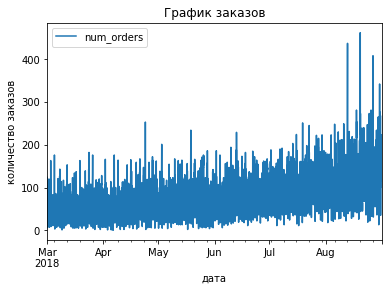

In [7]:
data.plot(xlabel='дата', ylabel='количество заказов', title='График заказов');

In [13]:
decomposed = seasonal_decompose(data) 

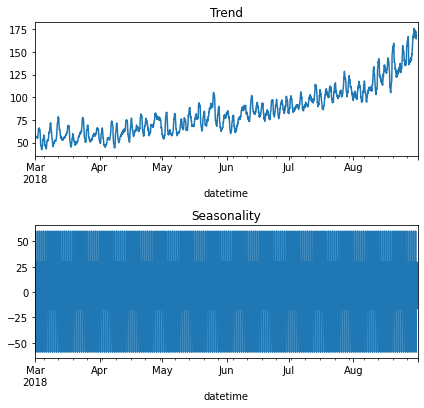

In [15]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.tight_layout()

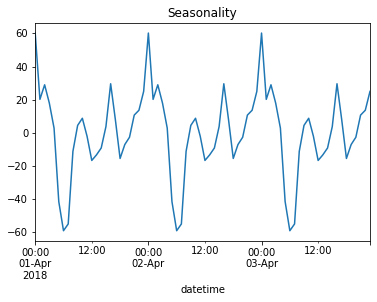

In [20]:
decomposed.seasonal['2018-04-01':'2018-04-03'].plot() 
plt.title('Seasonality');

Вывод: на графике тренда мы видим рост количества заказов. Сезонность имеет дневной характер.

<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены корреткно. Радует, что баланс классов был изучен.
</div>


<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Пожалуйста проведи сезонную декомпозицию, построй графики тренда и сезонности, сделай выводы.
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Добавил графики сезонности тренда и вывод.
</div>

<div class="alert alert-block alert-success">
<b>Успех (ревью 2):</b> Отлично, молодец!
</div>

### Добавляем фичи

In [21]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
        
    

make_features(data, 24,24)

<div class="alert alert-block alert-info">
<b>Совет: </b> Желательно было написать функцию таким образом, чтобы она возвращала новый датафрейм, а не изменяла глобальную переменную.
</div>

### Вывод

Мы добавили фичи для прогнозирования. Можно риступать к моделированию.

## Modeling

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   year          4416 non-null   int64  
 2   month         4416 non-null   int64  
 3   day           4416 non-null   int64  
 4   dayofweek     4416 non-null   int64  
 5   lag_1         4415 non-null   float64
 6   lag_2         4414 non-null   float64
 7   lag_3         4413 non-null   float64
 8   lag_4         4412 non-null   float64
 9   lag_5         4411 non-null   float64
 10  lag_6         4410 non-null   float64
 11  lag_7         4409 non-null   float64
 12  lag_8         4408 non-null   float64
 13  lag_9         4407 non-null   float64
 14  lag_10        4406 non-null   float64
 15  lag_11        4405 non-null   float64
 16  lag_12        4404 non-null   float64
 17  lag_13        4403 non-null

In [23]:
data.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# удаляем пустые строки

data.dropna(inplace=True)

выделяем таргет и разбиваем на трейн и тест

In [25]:
y = data['num_orders']
X = data.drop('num_orders', axis=1)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

<div class="alert alert-block alert-success">
<b>Успех:</b> Разбиение было сделано корректно.
</div>

In [27]:
def print_shape(ds):
    for i in ds:
        print(i.shape)
        
print_shape([X_train, X_test, y_train, y_test])

(3952, 29)
(440, 29)
(3952,)
(440,)


In [28]:
# готовим TimeSeriesSplit для кросс-валидации

ts_cv = TimeSeriesSplit(
    n_splits=3,
    gap=48
)

### Random forest

In [29]:
score = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

In [30]:
model_rfc = RandomForestRegressor(random_state=42)
params = {'n_estimators': range(3, 200, 10),
        'max_depth': range(3,50, 4),
    'min_samples_split': range(2,50, 5),
    'min_samples_leaf': range(2,50, 5),

         }

grid_cv = RandomizedSearchCV(model_rfc,
                    params,
                    n_iter=30,
                    cv=ts_cv,
                    verbose=10,
                    random_state=123,
                    scoring=score,
                    n_jobs=-1,
                         error_score='raise')




<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что для подбора параметров использовался метод основанный на кросс-валидации с подходящим под данные сплиттером.
</div>

In [31]:
model = grid_cv.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3; 1/30] START max_depth=39, min_samples_leaf=47, min_samples_split=42, n_estimators=63
[CV 1/3; 1/30] END max_depth=39, min_samples_leaf=47, min_samples_split=42, n_estimators=63; total time=   0.3s
[CV 2/3; 1/30] START max_depth=39, min_samples_leaf=47, min_samples_split=42, n_estimators=63
[CV 2/3; 1/30] END max_depth=39, min_samples_leaf=47, min_samples_split=42, n_estimators=63; total time=   0.6s
[CV 3/3; 1/30] START max_depth=39, min_samples_leaf=47, min_samples_split=42, n_estimators=63
[CV 3/3; 1/30] END max_depth=39, min_samples_leaf=47, min_samples_split=42, n_estimators=63; total time=   0.9s
[CV 1/3; 2/30] START max_depth=31, min_samples_leaf=42, min_samples_split=32, n_estimators=53
[CV 1/3; 2/30] END max_depth=31, min_samples_leaf=42, min_samples_split=32, n_estimators=53; total time=   0.2s
[CV 2/3; 2/30] START max_depth=31, min_samples_leaf=42, min_samples_split=32, n_estimators=53
[CV 2/3; 2/30] END ma

In [32]:
-model.best_score_

28.092794524036947

### LinearReggression

In [33]:
model_lr = RidgeCV(scoring=score, cv=ts_cv)
model_lr.fit(X_train, y_train)


RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
        cv=TimeSeriesSplit(gap=48, max_train_size=None, n_splits=3, test_size=None),
        scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False))

In [34]:
-model_lr.best_score_

27.59588060305639

### CatBoost

In [35]:
train_dataset = cb.Pool(X_train, 
                        y_train,
#                         model_lr.predict(X_train) 
                        ) 

In [36]:
cb_model = CatBoostRegressor(
            loss_function='RMSE',
            eval_metric='RMSE',
            learning_rate=0.01,
            num_boost_round=1000,
            early_stopping_rounds=10,
            verbose=False,
            random_seed=43,
                            )


In [37]:
cb_model.fit(X_train, y_train)

In [38]:
cb_model.best_score_['learn']['RMSE']

20.342383947436783

###  HistGradientBoostingRegressor

In [39]:
model_hgbr = HistGradientBoostingRegressor()    
    
cv_hgbr = cross_validate(
        model_hgbr,
        X_train,
        y_train,
        cv=ts_cv,
        scoring="neg_root_mean_squared_error",
    )

In [40]:
-cv_hgbr['test_score'].mean()

27.854378584019173

### Вывод

Лучший результат показал CatBoostRegressor - 20.34

<div class="alert alert-block alert-success">
<b>Успех:</b> Молодец, что попробовал разные модели в этом шаге!
</div>

## Тестирование лучшей модели

### Проверка на адекватность

In [41]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
mean_squared_error(y_train, dummy.predict(X_train), squared=False)

38.70541274453604

Наша модель показала результат лучше, чем болванка. Тест на адекватность пройден.

### Проверка на тестовых данных

In [48]:
y_pred = cb_model.predict(X_test)

In [43]:
mean_squared_error(y_test, y_pred, squared=False)

43.148859807692524

Вывод: 

Модель показала значение метрики 43, что лучше чем необходимое значение по техническому заданию.

In [49]:
y_pred = pd.Series(data=y_pred, index=y_test.index)

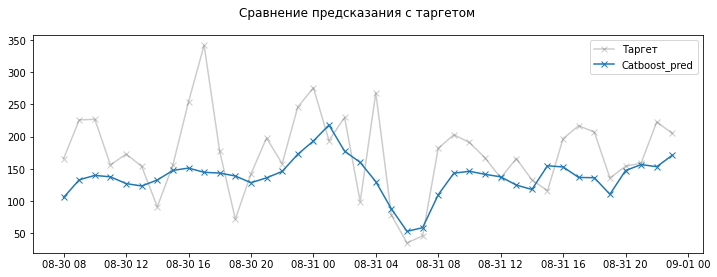

In [53]:
last_hours = slice(-40, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Сравнение предсказания с таргетом")
ax.plot(
    y_test[last_hours],
    "x-",
    alpha=0.2,
    label="Таргет",
    color="black",
)
ax.plot(
    y_pred[last_hours],
    "x-",
    label="Catboost_pred",
)
_ = ax.legend()

<div class="alert alert-block alert-success">
<b>Успех:</b> Тестирование было сделано правильно!
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Финальные предсказания можно было визуализирвоать: графики исходного и предсказанных рядов.
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Добавил график исходного и предсказанных рядов.
</div>

<div class="alert alert-block alert-success">
<b>Успех (ревью 2):</b> Спасибо!
</div>

## Вывод

В данном проекте мы строили модель прогнозирования количества заказов. 

На входе мы получили данные о заказах. В ходе подготовки данные были ресемплерованы с периодом 1 час. Для прогнозирования были добавлены столбцы со значениями отстающих данных, скользящего срднего и календарные признаки.

Были построены 4 модели со следующими параметрами на выходе:

| model        | RMSE       | 
| :----------- |:-----------| 
| RandomForest | 28.09      | 
| Ridge        | 27.59      | 
| CatBoost     | 20.34      |
| HGBRegressor | 27.85      |


Лучший результат показал CatBoostRegressor - 20.34

На тестовой выборке лучшая модель показала RMSE = 43, что превосходит необходимое значение по техническому заданию.



<div class="alert alert-block alert-success">
<b>Успех:</b> Приятно видеть вывод в конце проекта!
</div>